<a href="https://colab.research.google.com/github/adbyte/grade_prediction/blob/main/cleaned_dataset_grade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import random
from scipy.stats import truncnorm

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

def truncated_normal(mean, std, lower, upper):
    a, b = (lower - mean) / std, (upper - mean) / std
    return truncnorm.rvs(a, b, loc=mean, scale=std)

def generate_clean_student_dataset(n_students=15000):
    students = []

    for i in range(n_students):
        student_id = f"S{i+1:05d}"

        # Attendance and adherence
        attendance = int(round(truncated_normal(80, 10, 30, 100)))
        adherence = int(round(truncated_normal(4, 1, 0, 5)))

        # TA marks are influenced by attendance and adherence
        ta_base = (attendance / 100) * 15 + (adherence / 5) * 10  # total weight = 25
        ta_marks = int(round(min(25, max(0, ta_base + np.random.normal(0, 1.5)))))

        # Backlogs (random, but can affect test performance)
        backlogs = np.random.choice([0, 1, 2, 3], p=[0.7, 0.2, 0.07, 0.03])

        # Test marks are influenced negatively by backlogs
        distraction_penalty = backlogs * 1.5

        t1_marks = int(round(truncated_normal(15 - distraction_penalty, 2, 0, 20)))
        t2_marks = int(round(truncated_normal(15 - distraction_penalty, 2, 0, 20)))
        t3_marks = int(round(truncated_normal(27 - distraction_penalty, 3, 0, 35)))

        # GPA fields are random (they don't affect grade)
        prev_gpa = round(truncated_normal(6.5, 1.2, 0, 10), 2)
        cum_gpa = round(truncated_normal(6.8, 1.1, 0, 10), 2)

        # Total score (T1 + T2 + T3 + TA)
        total_score = t1_marks + t2_marks + t3_marks + ta_marks

        # Grade mapping
        if total_score >= 90:
            grade = 'A+'
        elif total_score >= 85:
            grade = 'A'
        elif total_score >= 75:
            grade = 'B+'
        elif total_score >= 65:
            grade = 'B'
        elif total_score >= 55:
            grade = 'C+'
        elif total_score >= 45:
            grade = 'C'
        elif total_score >= 35:
            grade = 'D+'
        elif total_score >= 25:
            grade = 'D'
        else:
            grade = 'F'

        student = {
            'Student_ID': student_id,
            'Previous_Semester_GPA': prev_gpa,
            'No_of_Backlogs': backlogs,
            'Cumulative_GPA': cum_gpa,
            'T1_Marks': t1_marks,
            'T2_Marks': t2_marks,
            'T3_Marks': t3_marks,
            'Attendance_Percentage': attendance,
            'TA_Marks': ta_marks,
            'Adherence_to_Deadlines': adherence,
            'Total_Score': total_score,
            'Final_Grade': grade
        }

        students.append(student)

    return pd.DataFrame(students)

# Generate the clean dataset
clean_df = generate_clean_student_dataset(15000)
clean_df.head()

,Student_ID,Previous_Semester_GPA,No_of_Backlogs,Cumulative_GPA,T1_Marks,T2_Marks,T3_Marks,Attendance_Percentage,TA_Marks,Adherence_to_Deadlines,Total_Score,Final_Grade
0,S00001,6.80,0,7.40,13,12,30,77,23,5,78,B+
1,S00002,5.88,1,6.87,12,12,23,59,21,5,68,B
2,S00003,5.49,0,6.84,14,15,29,78,16,3,74,B
3,S00004,8.66,0,7.75,13,12,32,82,17,2,74,B
4,S00005,5.72,0,7.26,15,11,31,75,16,3,73,B


In [ ]:
clean_df.to_csv('clean_student_dataset.csv', index=False)


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

# Load the clean dataset
df = pd.read_csv('clean_student_dataset.csv')

# Define Final_Grade numeric mapping based on total marks
grade_mapping = {
    'A+': 0, 'A': 1, 'B+': 2, 'B': 3,
    'C+': 4, 'C': 5, 'D+': 6, 'D': 7, 'F': 8
}
df['Grade_Label'] = df['Final_Grade'].map(grade_mapping)

# Drop unused columns
X = df.drop(['Student_ID', 'Final_Grade', 'Grade_Label'], axis=1)
y = df['Grade_Label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Evaluation function
results_df = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'Specificity', 'F1-score'])

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # Specificity
    cm = confusion_matrix(y_test, y_pred)
    tn = cm.sum() - (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
    fp = cm.sum(axis=0) - np.diag(cm)
    specificity = np.mean(tn / (tn + fp + 1e-6))

    global results_df
    new_row = pd.DataFrame([{
        'Model': model_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'Specificity': round(specificity, 4),
        'F1-score': round(f1, 4)
    }])

    results_df = pd.concat([results_df, new_row], ignore_index=True)

    return y_pred


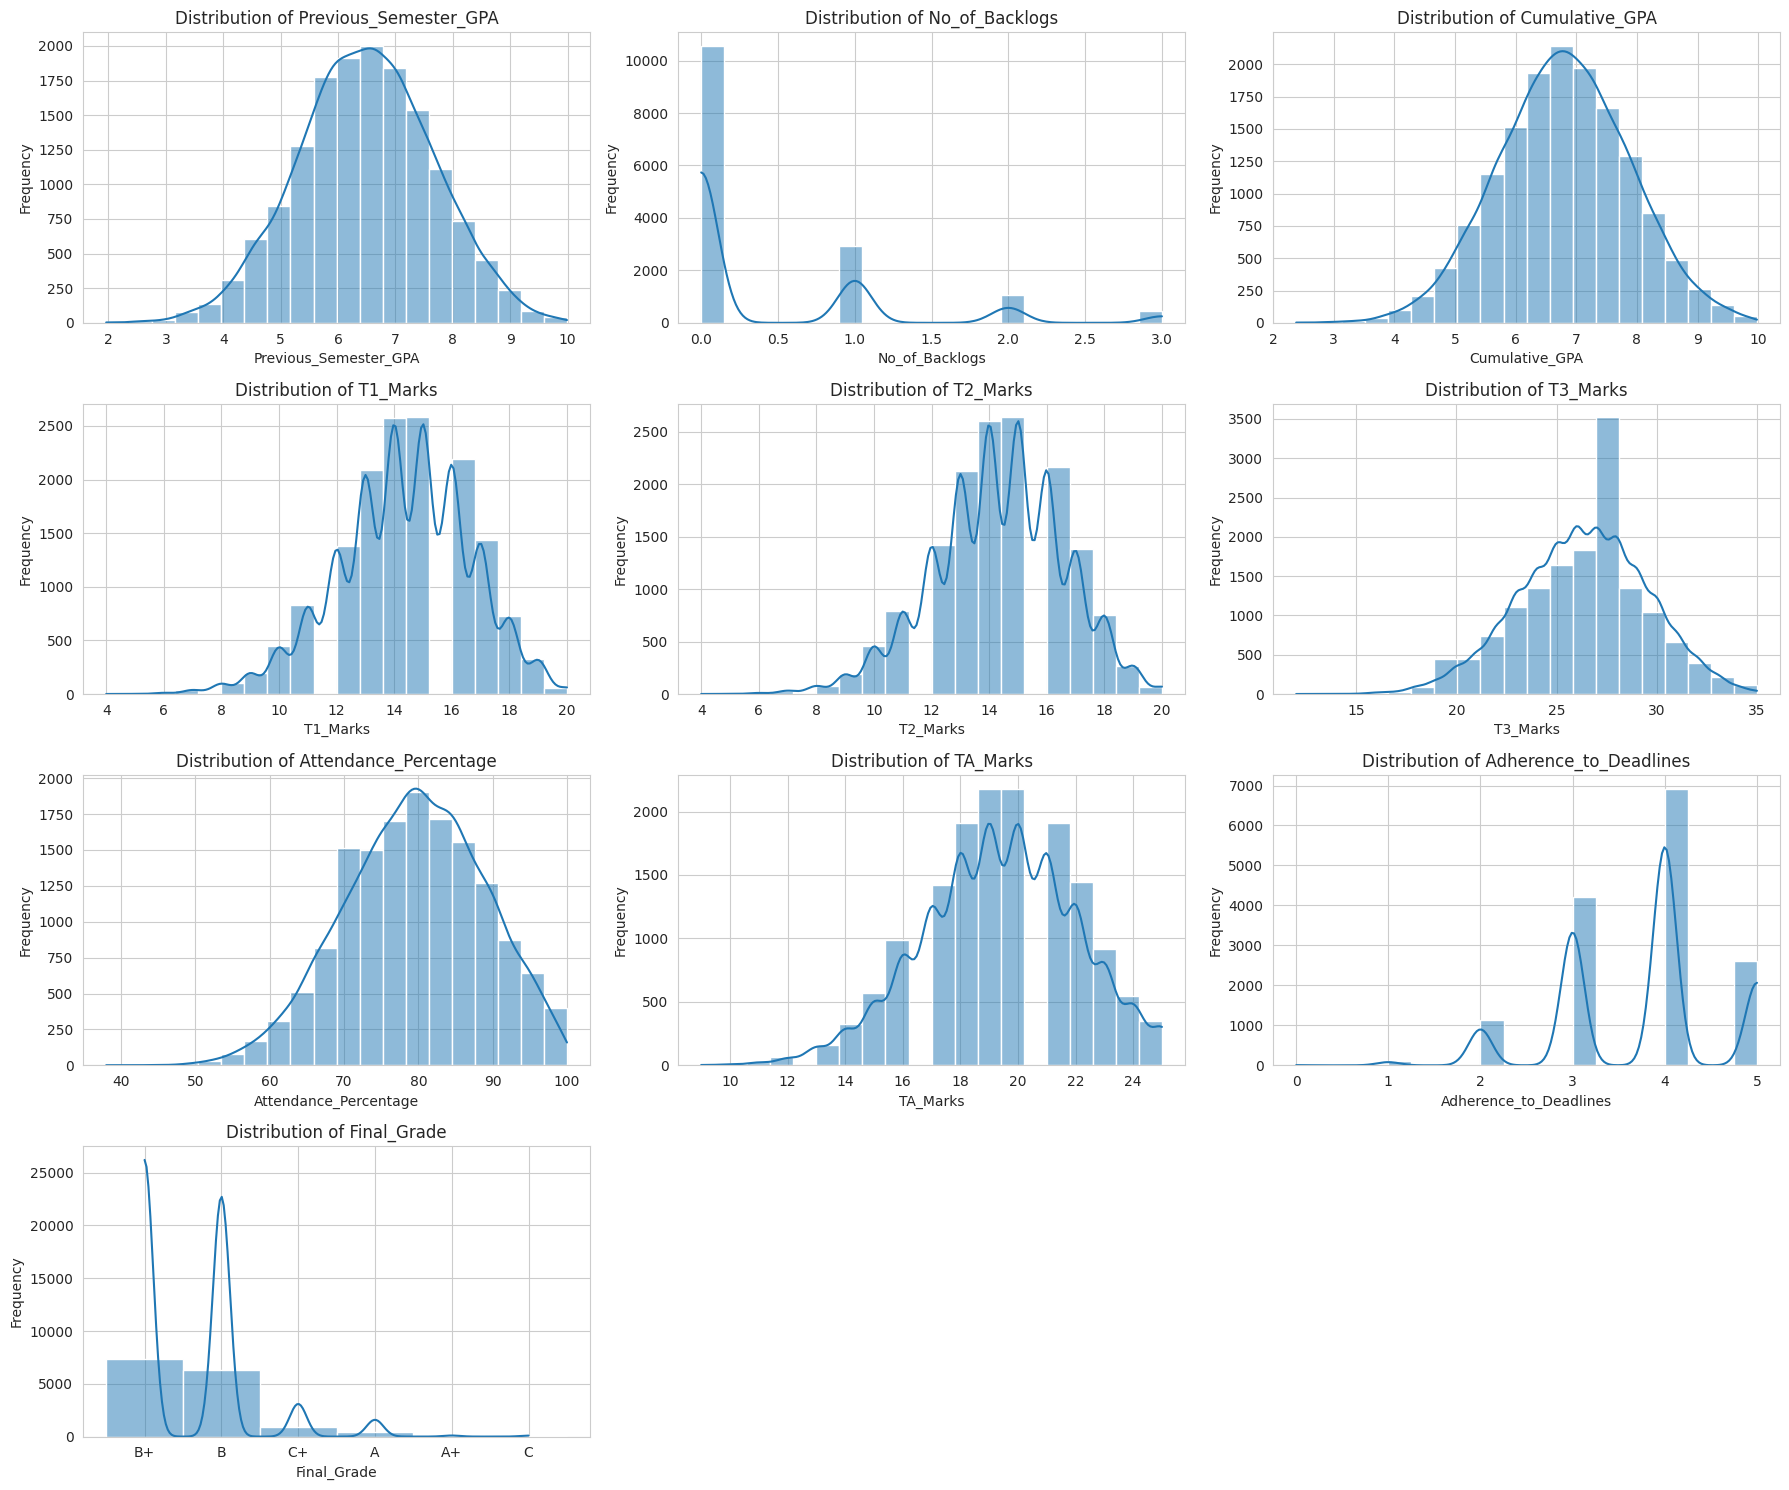

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load the clean dataset (assuming it's already saved as 'clean_student_dataset.csv')
df = pd.read_csv('clean_student_dataset.csv')

# Exclude 'Student_ID' and 'Grade_Label' if they exist from the plotting
# We also created 'Total_Score' which is the sum of other features, so we might want to exclude it from individual feature plots
features_to_plot = [col for col in df.columns if col not in ['Student_ID', 'Grade_Label', 'Total_Score']]

# Set up the plot style
sns.set_style("whitegrid")
plt.figure(figsize=(18, 15)) # Adjust figure size as needed

# Determine number of rows and columns for subplots dynamically
n_features = len(features_to_plot)
n_cols = 3 # You can adjust the number of columns
n_rows = (n_features + n_cols - 1) // n_cols

for i, feature in enumerate(features_to_plot):
    plt.subplot(n_rows, n_cols, i + 1) # Create subplot for each feature

    if df[feature].dtype in ['int64', 'float64']:
        # For numerical features, plot a histogram
        sns.histplot(df[feature], kde=True, bins=20)
        plt.title(f'Distribution of {feature}', fontsize=12)
        plt.xlabel(feature, fontsize=10)
        plt.ylabel('Frequency', fontsize=10)
    else:
        # For categorical or discrete numerical features with few unique values, plot a countplot
        # Check if it's a "categorical-like" numerical feature
        if df[feature].nunique() < 10 and df[feature].dtype in ['int64', 'float64']:
            sns.countplot(x=feature, data=df, palette='viridis')
            plt.title(f'Count of {feature}', fontsize=12)
            plt.xlabel(feature, fontsize=10)
            plt.ylabel('Count', fontsize=10)
        else:
            # Fallback for other data types, though not expected with this dataset
            sns.histplot(df[feature], kde=True, bins=20)
            plt.title(f'Distribution of {feature}', fontsize=12)
            plt.xlabel(feature, fontsize=10)
            plt.ylabel('Frequency', fontsize=10)


plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Tuned Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=300,


    random_state=42

)

# Train the model
rf_model.fit(X_train_scaled, y_train)

# Evaluate
evaluate_model(rf_model, X_test_scaled, y_test, "Random Forest (Tuned)")

# View the results
results_df.tail(1)  # Show just the Random Forest result


<ipython-input-18-c8e30fa82540>:57: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


,Model,Accuracy,Precision,Recall,Specificity,F1-score
0,Random Forest (Tuned),0.9997,0.999,0.9667,0.9999,0.981


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tabulate import tabulate

# Example data placeholders (replace if needed)
# X_train_scaled, y_train, X_test_scaled, y_test = ...

# --- Random Forest Hyperparameter Comparison ---
n_estimators_list = [10, 50, 100]
max_depth_list = [None, 5, 10]

rf_comparison_results = []

print("Generating Random Forest Hyperparameter Comparison Table...")
for n in n_estimators_list:
    for d in max_depth_list:
        model_config_name = f"n_estimators={n}, max_depth={d}"
        print(f"  Testing RF with {model_config_name}...")

        # Initialize model
        rf_model = RandomForestClassifier(
            n_estimators=n,
            max_depth=d,
            n_jobs=-1,
            random_state=42
        )

        # Train
        rf_model.fit(X_train_scaled, y_train)

        # Predict
        y_pred = rf_model.predict(X_test_scaled)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

        # Specificity
        cm = confusion_matrix(y_test, y_pred)
        specificity_list = []
        for i in range(cm.shape[0]):
            tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
            fp = cm[:, i].sum() - cm[i, i]
            specificity_list.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        specificity = np.mean(specificity_list)

        # Add to results
        rf_comparison_results.append({
            'Parameters': model_config_name,
            'Accuracy': round(accuracy, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'Specificity': round(specificity, 4),
            'F1-score': round(f1, 4)
        })

# Convert to DataFrame
rf_comparison_df = pd.DataFrame(rf_comparison_results)

# Sort by Accuracy
rf_comparison_df_sorted = rf_comparison_df.sort_values(by='Accuracy', ascending=False)

# Display table
print("\n--- Random Forest Hyperparameter Comparison Table (Sorted by Accuracy) ---")
rf_comparison_df_sorted


Generating Random Forest Hyperparameter Comparison Table...
  Testing RF with n_estimators=10, max_depth=None...
  Testing RF with n_estimators=10, max_depth=5...
  Testing RF with n_estimators=10, max_depth=10...
  Testing RF with n_estimators=50, max_depth=None...
  Testing RF with n_estimators=50, max_depth=5...
  Testing RF with n_estimators=50, max_depth=10...
  Testing RF with n_estimators=100, max_depth=None...
  Testing RF with n_estimators=100, max_depth=5...
  Testing RF with n_estimators=100, max_depth=10...

--- Random Forest Hyperparameter Comparison Table (Sorted by Accuracy) ---


,Parameters,Accuracy,Precision,Recall,Specificity,F1-score
3,"n_estimators=50, max_depth=None",0.9997,0.9990,0.9667,0.9999,0.9810
6,"n_estimators=100, max_depth=None",0.9997,0.9990,0.9667,0.9999,0.9810
8,"n_estimators=100, max_depth=10",0.9997,0.9990,0.9667,0.9999,0.9810
5,"n_estimators=50, max_depth=10",0.9997,0.9990,0.9667,0.9999,0.9810
0,"n_estimators=10, max_depth=None",0.9993,0.9989,0.9657,0.9998,0.9804
2,"n_estimators=10, max_depth=10",0.9993,0.9972,0.9389,0.9999,0.9649
4,"n_estimators=50, max_depth=5",0.9963,0.6514,0.6667,0.9994,0.6588
7,"n_estimators=100, max_depth=5",0.9963,0.6514,0.6667,0.9994,0.6588
1,"n_estimators=10, max_depth=5",0.9853,0.6508,0.6293,0.9960,0.6393


In [ ]:
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.ensemble import RandomForestClassifier

# Store results
comparison_table = pd.DataFrame(columns=['n_estimators', 'random_state', 'Accuracy'])

# Try multiple values of n_estimators and random_state
for n in [50, 100, 150, 200, 300]:
    for rs in [0, 42, 99]:
        model = RandomForestClassifier(n_estimators=n, random_state=rs)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        comparison_table.loc[len(comparison_table)] = [n, rs, acc]

# Show sorted results
comparison_table = comparison_table.sort_values(by='Accuracy', ascending=False).reset_index(drop=True)
print(comparison_table)


    n_estimators  random_state  Accuracy
0          300.0          99.0  1.000000
1          200.0          99.0  1.000000
2          150.0          99.0  1.000000
3          100.0           0.0  0.999667
4           50.0           0.0  0.999667
5           50.0          42.0  0.999667
6           50.0          99.0  0.999667
7          150.0           0.0  0.999667
8          100.0          99.0  0.999667
9          100.0          42.0  0.999667
10         150.0          42.0  0.999667
11         200.0          42.0  0.999667
12         200.0           0.0  0.999667
13         300.0           0.0  0.999667
14         300.0          42.0  0.999667


In [ ]:
from xgboost import XGBClassifier

# Tuned XGBoost model
xgb_model = XGBClassifier(
    n_estimators=300,         # Number of boosting rounds

    use_label_encoder=False,

    random_state=42,

)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Evaluate
evaluate_model(xgb_model, X_test_scaled, y_test, "XGBoost (Tuned)")

# Show result
print(results_df.tail(1))


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [11:37:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


             Model  Accuracy  Precision  Recall  Specificity  F1-score
1  XGBoost (Tuned)       1.0        1.0     1.0          1.0       1.0


In [ ]:
from sklearn.svm import SVC

# Apply Support Vector Machine Classifier with default parameters (except random_state)
svm_model_default = SVC(
    random_state=42 # Set for reproducibility, otherwise all other parameters are default
)

# Train the model
svm_model_default.fit(X_train_scaled, y_train)

# Evaluate the model
evaluate_model(svm_model_default, X_test_scaled, y_test, "SVM (Default)")

# View the updated results DataFrame
print(results_df)

                   Model  Accuracy  Precision  Recall  Specificity  F1-score
0  Random Forest (Tuned)    0.9997     0.9990  0.9667       0.9999    0.9810
1        XGBoost (Tuned)    1.0000     1.0000  1.0000       1.0000    1.0000
2          SVM (Default)    0.9903     0.6456  0.6445       0.9976    0.6451


In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tabulate import tabulate

# Example values (replace with your actual dataset if needed):
# X_train_scaled = ...
# y_train = ...
# X_test_scaled = ...
# y_test = ...

# --- SVM Hyperparameter Comparison ---
svm_c_values = [0.1, 1, 10]
svm_kernels = ['linear', 'rbf', 'poly']  # You can add 'sigmoid' too if needed

svm_comparison_results = []

print("Generating SVM Hyperparameter Comparison Table...")
for kernel in svm_kernels:
    for c in svm_c_values:
        model_config_name = f"C={c}, kernel='{kernel}'"
        print(f"  Testing SVM with {model_config_name}...")

        # Initialize SVM
        svm_model = SVC(C=c, kernel=kernel)

        # Train
        svm_model.fit(X_train_scaled, y_train)

        # Predict
        y_pred = svm_model.predict(X_test_scaled)

        # Metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

        # Specificity
        cm = confusion_matrix(y_test, y_pred)
        specificity_list = []
        for i in range(cm.shape[0]):
            tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
            fp = cm[:, i].sum() - cm[i, i]
            specificity_list.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
        specificity = np.mean(specificity_list)

        # Append results
        svm_comparison_results.append({
            'Parameters': model_config_name,
            'Accuracy': round(accuracy, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'Specificity': round(specificity, 4),
            'F1-score': round(f1, 4)
        })

# Create DataFrame
svm_comparison_df = pd.DataFrame(svm_comparison_results)

# Sort by Accuracy
svm_comparison_df_sorted = svm_comparison_df.sort_values(by='Accuracy', ascending=False)

# Display
print("\n--- SVM Hyperparameter Comparison Table (Sorted by Accuracy) ---")
svm_comparison_df_sorted


Generating SVM Hyperparameter Comparison Table...
  Testing SVM with C=0.1, kernel='linear'...
  Testing SVM with C=1, kernel='linear'...
  Testing SVM with C=10, kernel='linear'...
  Testing SVM with C=0.1, kernel='rbf'...
  Testing SVM with C=1, kernel='rbf'...
  Testing SVM with C=10, kernel='rbf'...
  Testing SVM with C=0.1, kernel='poly'...
  Testing SVM with C=1, kernel='poly'...
  Testing SVM with C=10, kernel='poly'...

--- SVM Hyperparameter Comparison Table (Sorted by Accuracy) ---


,Parameters,Accuracy,Precision,Recall,Specificity,F1-score
2,"C=10, kernel='linear'",1.0000,1.0000,1.0000,1.0000,1.0000
8,"C=10, kernel='poly'",0.9997,0.9722,0.9990,0.9999,0.9844
7,"C=1, kernel='poly'",0.9993,0.9721,0.9989,0.9998,0.9842
1,"C=1, kernel='linear'",0.9993,0.9657,0.9657,0.9999,0.9657
5,"C=10, kernel='rbf'",0.9973,0.9369,0.8794,0.9995,0.8932
0,"C=0.1, kernel='linear'",0.9970,0.8199,0.7333,0.9995,0.7550
4,"C=1, kernel='rbf'",0.9903,0.6456,0.6445,0.9976,0.6451
6,"C=0.1, kernel='poly'",0.9753,0.9792,0.7749,0.9925,0.8244
3,"C=0.1, kernel='rbf'",0.9687,0.6311,0.5498,0.9908,0.5802


In [ ]:
from sklearn.linear_model import LogisticRegression

# Apply Logistic Regression Classifier with default parameters
# For multiclass problems, LogisticRegression defaults to 'ovr' (One-vs-Rest) strategy
# or 'multinomial' if the solver supports it.
logistic_model = LogisticRegression(
    max_iter=1000, # Increased max_iter for potential convergence issues with default solver on some datasets
    random_state=42 # For reproducibility
)

# Train the model
logistic_model.fit(X_train_scaled, y_train)

# Evaluate the model
evaluate_model(logistic_model, X_test_scaled, y_test, "Logistic Regression")

# View the updated results DataFrame
print(results_df)

                   Model  Accuracy  Precision  Recall  Specificity  F1-score
0  Random Forest (Tuned)    0.9997     0.9990  0.9667       0.9999    0.9810
1        XGBoost (Tuned)    1.0000     1.0000  1.0000       1.0000    1.0000
2          SVM (Default)    0.9903     0.6456  0.6445       0.9976    0.6451
3    Logistic Regression    0.9960     0.6512  0.6648       0.9993    0.6578


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd
import numpy as np

log_reg_results = []

# Define combinations
penalty_solver_combinations = [
    ('l1', 'liblinear'),
    ('l2', 'lbfgs'),
    ('l2', 'saga'),
]

C_values = [0.001, 0.01, 0.1, 1, 10, 100]

print("Generating Logistic Regression Hyperparameter Comparison Table...")
for penalty, solver in penalty_solver_combinations:
    for c in C_values:
        try:
            model_name = f"C={c}, penalty='{penalty}', solver='{solver}'"
            print(f"  Testing LogisticRegression with {model_name}...")

            log_model = LogisticRegression(
                C=c, penalty=penalty, solver=solver,
                max_iter=1000, random_state=42
            )

            log_model.fit(X_train_scaled, y_train)
            y_pred = log_model.predict(X_test_scaled)

            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

            cm = confusion_matrix(y_test, y_pred)
            specificity_list = []
            for i in range(cm.shape[0]):
                tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
                fp = cm[:, i].sum() - cm[i, i]
                specificity_list.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
            specificity = np.mean(specificity_list)

            log_reg_results.append({
                'Parameters': model_name,
                'Accuracy': round(accuracy, 4),
                'Precision': round(precision, 4),
                'Recall': round(recall, 4),
                'Specificity': round(specificity, 4),
                'F1-score': round(f1, 4)
            })
        except Exception as e:
            print(f"  Skipped: {model_name} due to error: {e}")

log_reg_df = pd.DataFrame(log_reg_results)
log_reg_df_sorted = log_reg_df.sort_values(by='Accuracy', ascending=False)

print("\n--- Logistic Regression Hyperparameter Comparison Table ---")
log_reg_df_sorted


Generating Logistic Regression Hyperparameter Comparison Table...
  Testing LogisticRegression with C=0.001, penalty='l1', solver='liblinear'...
  Testing LogisticRegression with C=0.01, penalty='l1', solver='liblinear'...
  Testing LogisticRegression with C=0.1, penalty='l1', solver='liblinear'...
  Testing LogisticRegression with C=1, penalty='l1', solver='liblinear'...
  Testing LogisticRegression with C=10, penalty='l1', solver='liblinear'...
  Testing LogisticRegression with C=100, penalty='l1', solver='liblinear'...
  Testing LogisticRegression with C=0.001, penalty='l2', solver='lbfgs'...
  Testing LogisticRegression with C=0.01, penalty='l2', solver='lbfgs'...
  Testing LogisticRegression with C=0.1, penalty='l2', solver='lbfgs'...
  Testing LogisticRegression with C=1, penalty='l2', solver='lbfgs'...
  Testing LogisticRegression with C=10, penalty='l2', solver='lbfgs'...
  Testing LogisticRegression with C=100, penalty='l2', solver='lbfgs'...
  Testing LogisticRegression with 

,Parameters,Accuracy,Precision,Recall,Specificity,F1-score
11,"C=100, penalty='l2', solver='lbfgs'",0.9997,0.9990,0.9667,0.9999,0.9810
17,"C=100, penalty='l2', solver='saga'",0.9997,0.9990,0.9667,0.9999,0.9810
10,"C=10, penalty='l2', solver='lbfgs'",0.9993,0.9972,0.9389,0.9999,0.9649
16,"C=10, penalty='l2', solver='saga'",0.9993,0.9972,0.9389,0.9999,0.9649
9,"C=1, penalty='l2', solver='lbfgs'",0.9960,0.6512,0.6648,0.9993,0.6578
15,"C=1, penalty='l2', solver='saga'",0.9960,0.6512,0.6648,0.9993,0.6578
14,"C=0.1, penalty='l2', solver='saga'",0.9777,0.6380,0.5808,0.9936,0.6043
8,"C=0.1, penalty='l2', solver='lbfgs'",0.9777,0.6380,0.5808,0.9936,0.6043
13,"C=0.01, penalty='l2', solver='saga'",0.9423,0.4967,0.4394,0.9826,0.4532
7,"C=0.01, penalty='l2', solver='lbfgs'",0.9423,0.4967,0.4394,0.9826,0.4532


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier(
    n_neighbors = 11,
    weights = 'distance',
    n_jobs=-1
)

# Train the model
knn_model.fit(X_train_scaled, y_train)

# Evaluate the model
evaluate_model(knn_model, X_test_scaled, y_test, "K-Nearest Neighbors")

# View the updated results DataFrame
print(results_df)

                           Model  Accuracy  Precision  Recall  Specificity  \
0          Random Forest (Tuned)    0.9997     0.9990  0.9667       0.9999   
1                XGBoost (Tuned)    1.0000     1.0000  1.0000       1.0000   
2                  SVM (Default)    0.9903     0.6456  0.6445       0.9976   
3            Logistic Regression    0.9960     0.6512  0.6648       0.9993   
4            K-Nearest Neighbors    0.9110     0.7579  0.5406       0.9736   
5           Neural Network (MLP)    0.9970     0.8246  0.7749       0.9994   
6         Naive Bayes (Gaussian)    0.9130     0.8362  0.9216       0.9766   
7   Linear Discriminant Analysis    0.9813     0.7629  0.8109       0.9960   
8            LightGBM Classifier    1.0000     1.0000  1.0000       1.0000   
9            CatBoost Classifier    1.0000     1.0000  1.0000       1.0000   
10          Neural Network (MLP)    0.9987     0.9356  0.9693       0.9998   
11           K-Nearest Neighbors    0.9193     0.5965  0.5046   

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tabulate import tabulate # For beautiful table printing

# Assume X_train_scaled, y_train, X_test_scaled, y_test are already defined and prepared
# Example placeholders (replace with your actual scaled data if running this snippet alone):
# X_train_scaled = np.random.rand(100, 10)
# y_train = np.random.randint(0, 5, 100)
# X_test_scaled = np.random.rand(20, 10)
# y_test = np.random.randint(0, 5, 20)


# --- KNN Comparison Table Generation ---
knn_n_neighbors_values = [1, 3, 5, 7, 9, 11, 15, 21] # Values for 'k' to test
knn_weights_values = ['uniform', 'distance']        # Values for 'weights' to test

knn_comparison_results = [] # This list will collect dictionaries of results for the new table

print("Generating KNN Hyperparameter Comparison Table...")
for n in knn_n_neighbors_values:
    for w in knn_weights_values:
        model_config_name = f"k={n}, weights='{w}'"
        print(f"  Testing KNN with {model_config_name}...") # Print progress

        # Apply K-Nearest Neighbors (KNN) Classifier with current parameters
        knn_model = KNeighborsClassifier(
            n_neighbors=n,
            weights=w,
            n_jobs=-1 # Use all available CPU cores for faster computation
        )

        # Train the model
        knn_model.fit(X_train_scaled, y_train)

        # Make predictions
        y_pred = knn_model.predict(X_test_scaled)

        # Calculate metrics directly for this comparison table
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
        recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
        f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

        # Specificity calculation for multiclass
        cm = confusion_matrix(y_test, y_pred)
        specificity_list = []
        for i in range(cm.shape[0]):
            tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
            fp = cm[:, i].sum() - cm[i, i]
            if (tn + fp) > 0:
                specificity_list.append(tn / (tn + fp))
            else:
                specificity_list.append(0)
        specificity = np.mean(specificity_list) if specificity_list else 0


        # Add results to the list
        knn_comparison_results.append({
            'Parameters': model_config_name,
            'Accuracy': round(accuracy, 4),
            'Precision': round(precision, 4),
            'Recall': round(recall, 4),
            'Specificity': round(specificity, 4),
            'F1-score': round(f1, 4)
        })

# Convert the list of results into a pandas DataFrame
knn_comparison_df = pd.DataFrame(knn_comparison_results)

# Sort the comparison table by Accuracy in descending order (highest accuracy first)
knn_comparison_df_sorted = knn_comparison_df.sort_values(by='Accuracy', ascending=False)

# Print the beautiful comparison table without showing the index
print("\n--- KNN Hyperparameter Comparison Table (Sorted by Accuracy) ---")
knn_comparison_df_sorted

Generating KNN Hyperparameter Comparison Table...
  Testing KNN with k=1, weights='uniform'...
  Testing KNN with k=1, weights='distance'...
  Testing KNN with k=3, weights='uniform'...
  Testing KNN with k=3, weights='distance'...
  Testing KNN with k=5, weights='uniform'...
  Testing KNN with k=5, weights='distance'...
  Testing KNN with k=7, weights='uniform'...
  Testing KNN with k=7, weights='distance'...
  Testing KNN with k=9, weights='uniform'...
  Testing KNN with k=9, weights='distance'...
  Testing KNN with k=11, weights='uniform'...
  Testing KNN with k=11, weights='distance'...
  Testing KNN with k=15, weights='uniform'...
  Testing KNN with k=15, weights='distance'...
  Testing KNN with k=21, weights='uniform'...
  Testing KNN with k=21, weights='distance'...

--- KNN Hyperparameter Comparison Table (Sorted by Accuracy) ---


,Parameters,Accuracy,Precision,Recall,Specificity,F1-score
11,"k=11, weights='distance'",0.9193,0.5965,0.5046,0.9758,0.5360
10,"k=11, weights='uniform'",0.9190,0.5990,0.5036,0.9757,0.5352
12,"k=15, weights='uniform'",0.9177,0.6018,0.5004,0.9752,0.5336
13,"k=15, weights='distance'",0.9177,0.5983,0.4995,0.9752,0.5324
15,"k=21, weights='distance'",0.9167,0.5959,0.4886,0.9748,0.5205
14,"k=21, weights='uniform'",0.9150,0.5943,0.4854,0.9743,0.5172
8,"k=9, weights='uniform'",0.9130,0.5957,0.4954,0.9739,0.5283
9,"k=9, weights='distance'",0.9127,0.5923,0.4952,0.9738,0.5276
5,"k=5, weights='distance'",0.9117,0.7587,0.5417,0.9738,0.5905
4,"k=5, weights='uniform'",0.9110,0.7579,0.5406,0.9736,0.5892


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100,50),
    activation='relu',
    solver='adam',
    max_iter=700,
    random_state=42,
    verbose=False,
    early_stopping=True,
    n_iter_no_change=15
)

# Train the model
# (Assumes X_train_scaled and y_train are already defined and prepared)
mlp_model.fit(X_train_scaled, y_train)

# Evaluate the model
# (Assumes evaluate_model function, X_test_scaled, y_test, and results_df are already defined)
evaluate_model(mlp_model, X_test_scaled, y_test, "Neural Network (MLP)")

# View the updated results DataFrame
# (Assumes results_df is accessible and will be printed)
print(results_df)

                           Model  Accuracy  Precision  Recall  Specificity  \
0          Random Forest (Tuned)    0.9997     0.9990  0.9667       0.9999   
1                XGBoost (Tuned)    1.0000     1.0000  1.0000       1.0000   
2                  SVM (Default)    0.9903     0.6456  0.6445       0.9976   
3            Logistic Regression    0.9960     0.6512  0.6648       0.9993   
4            K-Nearest Neighbors    0.9110     0.7579  0.5406       0.9736   
5           Neural Network (MLP)    0.9970     0.8246  0.7749       0.9994   
6         Naive Bayes (Gaussian)    0.9130     0.8362  0.9216       0.9766   
7   Linear Discriminant Analysis    0.9813     0.7629  0.8109       0.9960   
8            LightGBM Classifier    1.0000     1.0000  1.0000       1.0000   
9            CatBoost Classifier    1.0000     1.0000  1.0000       1.0000   
10          Neural Network (MLP)    0.9903     0.6451  0.6401       0.9976   
11          Neural Network (MLP)    0.9987     0.9356  0.9693   

In [ ]:
import pandas as pd
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

mlp_hidden_layer_sizes_values = [
    (50,),           # One hidden layer with 50 neurons
    (100,),          # One hidden layer with 100 neurons
    (50, 50),        # Two hidden layers, 50 neurons each
    (100, 50)        # Two hidden layers, 100 then 50 neurons
]
mlp_activation_values = ['relu', 'tanh'] # Common activation functions
mlp_solver_values = ['adam', 'sgd']      # Common solvers

mlp_comparison_results = [] # This list will collect dictionaries of results

print("Generating MLPClassifier Hyperparameter Comparison Table...")
for hls in mlp_hidden_layer_sizes_values:
    for act in mlp_activation_values:
        for solv in mlp_solver_values:
            model_config_name = f"HLS={hls}, Act='{act}', Solver='{solv}'"
            print(f"  Testing MLP with {model_config_name}...") # Print progress

            # Apply MLPClassifier with current parameters
            mlp_model = MLPClassifier(
                hidden_layer_sizes=hls,
                activation=act,
                solver=solv,
                max_iter=700, # Increased max_iter as NNs often need more epochs
                random_state=42,
                verbose=False, # Keep false to avoid verbose output for each iteration during this loop
                early_stopping=True,
                n_iter_no_change=15 # Number of iterations with no improvement to wait before stopping
            )

            # Train the model
            # For 'sgd' solver, increasing max_iter or adding a learning rate schedule might be needed for convergence
            try:
                mlp_model.fit(X_train_scaled, y_train)
            except Exception as e:
                print(f"    Warning: MLP training failed for {model_config_name}: {e}. Skipping this config.")
                continue # Skip to next combination if training fails

            # Make predictions
            y_pred = mlp_model.predict(X_test_scaled)

            # Calculate metrics directly for this comparison table
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
            recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
            f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

            # Specificity calculation for multiclass
            cm = confusion_matrix(y_test, y_pred)
            specificity_list = []
            for i in range(cm.shape[0]):
                tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
                fp = cm[:, i].sum() - cm[i, i]
                if (tn + fp) > 0:
                    specificity_list.append(tn / (tn + fp))
                else:
                    specificity_list.append(0)
            specificity = np.mean(specificity_list) if specificity_list else 0

            # Add results to the list
            mlp_comparison_results.append({
                'Parameters': model_config_name,
                'Accuracy': round(accuracy, 4),
                'Precision': round(precision, 4),
                'Recall': round(recall, 4),
                'Specificity': round(specificity, 4),
                'F1-score': round(f1, 4)
            })

# Convert the list of results into a pandas DataFrame
mlp_comparison_df = pd.DataFrame(mlp_comparison_results)

# Sort the comparison table by Accuracy in descending order (highest accuracy first)
mlp_comparison_df_sorted = mlp_comparison_df.sort_values(by='Accuracy', ascending=False)

# Display the sorted DataFrame (relying on default pandas display in interactive environments)
# This will show the index column and standard pandas formatting.
print("\n--- MLPClassifier Hyperparameter Comparison Table (Sorted by Accuracy) ---")
mlp_comparison_df_sorted

Generating MLPClassifier Hyperparameter Comparison Table...
  Testing MLP with HLS=(50,), Act='relu', Solver='adam'...
  Testing MLP with HLS=(50,), Act='relu', Solver='sgd'...
  Testing MLP with HLS=(50,), Act='tanh', Solver='adam'...
  Testing MLP with HLS=(50,), Act='tanh', Solver='sgd'...
  Testing MLP with HLS=(100,), Act='relu', Solver='adam'...
  Testing MLP with HLS=(100,), Act='relu', Solver='sgd'...
  Testing MLP with HLS=(100,), Act='tanh', Solver='adam'...
  Testing MLP with HLS=(100,), Act='tanh', Solver='sgd'...
  Testing MLP with HLS=(50, 50), Act='relu', Solver='adam'...
  Testing MLP with HLS=(50, 50), Act='relu', Solver='sgd'...
  Testing MLP with HLS=(50, 50), Act='tanh', Solver='adam'...
  Testing MLP with HLS=(50, 50), Act='tanh', Solver='sgd'...
  Testing MLP with HLS=(100, 50), Act='relu', Solver='adam'...
  Testing MLP with HLS=(100, 50), Act='relu', Solver='sgd'...
  Testing MLP with HLS=(100, 50), Act='tanh', Solver='adam'...
  Testing MLP with HLS=(100, 50), 

,Parameters,Accuracy,Precision,Recall,Specificity,F1-score
12,"HLS=(100, 50), Act='relu', Solver='adam'",0.9987,0.9356,0.9693,0.9998,0.9440
4,"HLS=(100,), Act='relu', Solver='adam'",0.9970,0.8246,0.7749,0.9994,0.7942
8,"HLS=(50, 50), Act='relu', Solver='adam'",0.9967,0.9306,0.9247,0.9992,0.9276
14,"HLS=(100, 50), Act='tanh', Solver='adam'",0.9960,0.6513,0.6657,0.9993,0.6583
6,"HLS=(100,), Act='tanh', Solver='adam'",0.9947,0.6506,0.6609,0.9989,0.6556
0,"HLS=(50,), Act='relu', Solver='adam'",0.9947,0.6496,0.6590,0.9989,0.6543
2,"HLS=(50,), Act='tanh', Solver='adam'",0.9947,0.6505,0.6600,0.9989,0.6552
10,"HLS=(50, 50), Act='tanh', Solver='adam'",0.9943,0.6502,0.6572,0.9987,0.6537
13,"HLS=(100, 50), Act='relu', Solver='sgd'",0.9923,0.6466,0.6495,0.9982,0.6480
15,"HLS=(100, 50), Act='tanh', Solver='sgd'",0.9903,0.6476,0.6384,0.9975,0.6428


In [ ]:
from sklearn.naive_bayes import GaussianNB


gnb_model = GaussianNB()


gnb_model.fit(X_train_scaled, y_train)


evaluate_model(gnb_model, X_test_scaled, y_test, "Naive Bayes (Gaussian)")


print(results_df)

                    Model  Accuracy  Precision  Recall  Specificity  F1-score
0   Random Forest (Tuned)    0.9997     0.9990  0.9667       0.9999    0.9810
1         XGBoost (Tuned)    1.0000     1.0000  1.0000       1.0000    1.0000
2           SVM (Default)    0.9903     0.6456  0.6445       0.9976    0.6451
3     Logistic Regression    0.9960     0.6512  0.6648       0.9993    0.6578
4     K-Nearest Neighbors    0.9110     0.7579  0.5406       0.9736    0.5892
5    Neural Network (MLP)    0.9970     0.8246  0.7749       0.9994    0.7942
6  Naive Bayes (Gaussian)    0.9130     0.8362  0.9216       0.9766    0.8721


In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tabulate import tabulate

# Example placeholders – make sure these exist in your code
# X_train_scaled, y_train, X_test_scaled, y_test = ...

# Range of var_smoothing values to test
var_smoothing_values = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4]

nb_comparison_results = []

print("Generating Naive Bayes Hyperparameter Comparison Table...")
for smoothing in var_smoothing_values:
    model_config_name = f"var_smoothing={smoothing}"
    print(f"  Testing GaussianNB with {model_config_name}...")

    # Create and train model
    nb_model = GaussianNB(var_smoothing=smoothing)
    nb_model.fit(X_train_scaled, y_train)

    # Predict
    y_pred = nb_model.predict(X_test_scaled)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

    # Specificity
    cm = confusion_matrix(y_test, y_pred)
    specificity_list = []
    for i in range(cm.shape[0]):
        tn = cm.sum() - (cm[i, :].sum() + cm[:, i].sum() - cm[i, i])
        fp = cm[:, i].sum() - cm[i, i]
        specificity_list.append(tn / (tn + fp) if (tn + fp) > 0 else 0)
    specificity = np.mean(specificity_list)

    # Collect results
    nb_comparison_results.append({
        'Parameters': model_config_name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'Specificity': round(specificity, 4),
        'F1-score': round(f1, 4)
    })

# Convert to DataFrame
nb_comparison_df = pd.DataFrame(nb_comparison_results)

# Sort by Accuracy
nb_comparison_df_sorted = nb_comparison_df.sort_values(by='Accuracy', ascending=False)

# Print table
print("\n--- Naive Bayes (Gaussian) Hyperparameter Comparison Table ---")
nb_comparison_df_sorted


Generating Naive Bayes Hyperparameter Comparison Table...
  Testing GaussianNB with var_smoothing=1e-09...
  Testing GaussianNB with var_smoothing=1e-08...
  Testing GaussianNB with var_smoothing=1e-07...
  Testing GaussianNB with var_smoothing=1e-06...
  Testing GaussianNB with var_smoothing=1e-05...
  Testing GaussianNB with var_smoothing=0.0001...

--- Naive Bayes (Gaussian) Hyperparameter Comparison Table ---


,Parameters,Accuracy,Precision,Recall,Specificity,F1-score
0,var_smoothing=1e-09,0.913,0.8362,0.9216,0.9766,0.8721
1,var_smoothing=1e-08,0.913,0.8362,0.9216,0.9766,0.8721
2,var_smoothing=1e-07,0.913,0.8362,0.9216,0.9766,0.8721
3,var_smoothing=1e-06,0.913,0.8362,0.9216,0.9766,0.8721
4,var_smoothing=1e-05,0.913,0.8362,0.9216,0.9766,0.8721
5,var_smoothing=0.0001,0.913,0.8362,0.9216,0.9766,0.8721


In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda_model = LinearDiscriminantAnalysis()


lda_model.fit(X_train_scaled, y_train)

evaluate_model(lda_model, X_test_scaled, y_test, "Linear Discriminant Analysis")


print(results_df)

                          Model  Accuracy  Precision  Recall  Specificity  \
0         Random Forest (Tuned)    0.9997     0.9990  0.9667       0.9999   
1               XGBoost (Tuned)    1.0000     1.0000  1.0000       1.0000   
2                 SVM (Default)    0.9903     0.6456  0.6445       0.9976   
3           Logistic Regression    0.9960     0.6512  0.6648       0.9993   
4           K-Nearest Neighbors    0.9110     0.7579  0.5406       0.9736   
5          Neural Network (MLP)    0.9970     0.8246  0.7749       0.9994   
6        Naive Bayes (Gaussian)    0.9130     0.8362  0.9216       0.9766   
7  Linear Discriminant Analysis    0.9813     0.7629  0.8109       0.9960   

   F1-score  
0    0.9810  
1    1.0000  
2    0.6451  
3    0.6578  
4    0.5892  
5    0.7942  
6    0.8721  
7    0.7852  


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

print("\nEvaluating Linear Regression...")

linreg_model = LinearRegression()
linreg_model.fit(X_train_scaled, y_train)
y_pred = linreg_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Linear Regression Performance ---")
print(tabulate([{
    'MSE': round(mse, 4),
    'MAE': round(mae, 4),
    'R²': round(r2, 4)
}], headers='keys', tablefmt='pretty'))



Evaluating Linear Regression...

--- Linear Regression Performance ---
+--------+--------+-------+
|  MSE   |  MAE   |  R²   |
+--------+--------+-------+
| 0.0825 | 0.2486 | 0.815 |
+--------+--------+-------+


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tabulate import tabulate  # Ensure this is imported
import numpy as np

print("\nEvaluating Linear Regression...")

linreg_model = LinearRegression()
linreg_model.fit(X_train_scaled, y_train)
y_pred = linreg_model.predict(X_test_scaled)

# Performance metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\n--- Linear Regression Performance ---")
print(tabulate([{
    'MSE': round(mse, 4),
    'MAE': round(mae, 4),
    'R²': round(r2, 4)
}], headers='keys', tablefmt='pretty'))

# --- Generate and print the linear equation ---
coefs = linreg_model.coef_
intercept = linreg_model.intercept_

# If using NumPy arrays, name features as x0, x1, ...
terms = [f"{round(coef, 4)}*x{i}" for i, coef in enumerate(coefs)]
equation = " + ".join(terms) + f" + {round(intercept, 4)}"

print("\n--- Linear Regression Equation ---")
print(f"y = {equation}")



Evaluating Linear Regression...

--- Linear Regression Performance ---
+--------+--------+-------+
|  MSE   |  MAE   |  R²   |
+--------+--------+-------+
| 0.0825 | 0.2486 | 0.815 |
+--------+--------+-------+

--- Linear Regression Equation ---
y = -0.0006*x0 + -0.0015*x1 + -0.0026*x2 + -0.1319*x3 + -0.1245*x4 + -0.1814*x5 + -0.0047*x6 + -0.1511*x7 + -0.0039*x8 + -0.2638*x9 + 2.5095


In [ ]:
pip install lightgbm

In [ ]:
from lightgbm import LGBMClassifier

# Apply LightGBM Classifier
# LightGBM is a fast, high-performance gradient boosting framework.
# It's highly effective for tabular data, similar to XGBoost.
# Key parameters:
# n_estimators: Number of boosting rounds (trees).
# learning_rate: Step size shrinkage.
# num_leaves: Max number of leaves in one tree (key for complexity control).
# objective: Loss function; 'multiclass' for your grade prediction task.
lgbm_model = LGBMClassifier(
    n_estimators=100,         # Number of boosting rounds
    learning_rate=0.1,        # Step size shrinkage
    num_leaves=31,            # Max number of leaves in one tree (default)
    objective='multiclass',   # Specify objective for multiclass classification
    num_class=len(y.unique()),# Number of target classes (important for multiclass)
    random_state=42,          # For reproducibility
    n_jobs=-1                 # Use all available CPU cores
)

# Train the model
# (Assumes X_train_scaled and y_train are already defined and prepared)
lgbm_model.fit(X_train_scaled, y_train)

# Evaluate the model
# (Assumes evaluate_model function, X_test_scaled, y_test, and results_df are already defined)
evaluate_model(lgbm_model, X_test_scaled, y_test, "LightGBM Classifier")

# View the updated results DataFrame
# (Assumes results_df is accessible and will be printed)
print(results_df)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 693
[LightGBM] [Info] Number of data points in the train set: 12000, number of used features: 10
[LightGBM] [Info] Start training from score -6.301619
[LightGBM] [Info] Start training from score -3.523365
[LightGBM] [Info] Start training from score -0.719491
[LightGBM] [Info] Start training from score -0.861763
[LightGBM] [Info] Start training from score -2.855970
[LightGBM] [Info] Start training from score -6.348139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [ ]:
import pandas as pd
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
import warnings

# Suppress verbose output from LightGBM during grid search
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. SETUP: Generate a synthetic dataset ---
X, y = make_classification(
    n_samples=1000,
    n_features=20,
    n_informative=10,
    n_redundant=5,
    n_classes=4,
    n_clusters_per_class=2,
    random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
num_classes = len(pd.unique(y))

# --- 2. DISCOVERY: Find the best hyperparameters using GridSearchCV ---
print("Searching for optimal hyperparameters with GridSearchCV...")

# Define a search grid with a wider range of parameters
search_grid = {
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [200, 300, 400],
    'num_leaves': [20, 31, 40],
    'max_depth': [-1, 10, 15],
    'reg_alpha': [0.1, 0.5], # L1 regularization
    'reg_lambda': [0.1, 0.5] # L2 regularization
}

# Base model for grid search
base_model = LGBMClassifier(objective='multiclass', num_class=num_classes, random_state=42, n_jobs=-1)

# Set up GridSearchCV
# cv=5 means 5-fold cross-validation
grid_search = GridSearchCV(estimator=base_model, param_grid=search_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)

# Run the search
grid_search.fit(X_train, y_train)

# Get the best parameters found by the search
best_params = grid_search.best_params_
print(f"Optimal parameters found: {best_params}\n")


# --- 3. COMPARISON: Run the comparison including the best parameters ---

# Define the original list of hyperparameter combinations to test
param_grid = [
    # Baseline
    {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': -1},
    # More estimators, smaller learning rate
    {'n_estimators': 300, 'learning_rate': 0.05, 'num_leaves': 31, 'max_depth': -1},
    # Deeper trees
    {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 50, 'max_depth': 10},
    # Shallower trees
    {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 20, 'max_depth': 5},
    # Higher learning rate, fewer estimators
    {'n_estimators': 50, 'learning_rate': 0.2, 'num_leaves': 31, 'max_depth': -1},
]

# Create a dictionary for the best params to add to the comparison list
# (We remove regularization terms if they are not in the main comparison)
best_params_for_comparison = {
    'n_estimators': best_params['n_estimators'],
    'learning_rate': best_params['learning_rate'],
    'num_leaves': best_params['num_leaves'],
    'max_depth': best_params['max_depth'],
}

# Add the best parameters to our grid to ensure they are in the final table
if best_params_for_comparison not in param_grid:
    param_grid.append(best_params_for_comparison)


# A list to store the performance metrics for each model
model_performance_records = []

# Loop through the final parameter grid
for params in param_grid:
    # Create the LGBMClassifier with the current parameters
    lgbm_model = LGBMClassifier(
        n_estimators=params['n_estimators'],
        learning_rate=params['learning_rate'],
        num_leaves=params['num_leaves'],
        max_depth=params['max_depth'],
        # Include regularization if available from the grid search result
        reg_alpha=best_params.get('reg_alpha', 0) if params == best_params_for_comparison else 0,
        reg_lambda=best_params.get('reg_lambda', 0) if params == best_params_for_comparison else 0,
        objective='multiclass',
        num_class=num_classes,
        random_state=42,
        n_jobs=-1
    )
    lgbm_model.fit(X_train, y_train)
    y_pred = lgbm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    model_performance_records.append({
        'Parameters': 'Optimal (Found by Search)' if params == best_params_for_comparison else 'Manual',
        'n_estimators': params['n_estimators'],
        'learning_rate': params['learning_rate'],
        'num_leaves': params['num_leaves'],
        'max_depth': params['max_depth'],
        'Accuracy': f"{accuracy:.4f}"
    })

# Create the final DataFrame
model_comparison_df = pd.DataFrame(model_performance_records)

# Sort by accuracy to highlight the best performer
model_comparison_df = model_comparison_df.sort_values(by='Accuracy', ascending=False)


# Display the final comparison table
print("--- Hyperparameter Comparison Table (including optimal params) ---")
print(model_comparison_df.to_markdown(index=False))

Searching for optimal hyperparameters with GridSearchCV...


KeyboardInterrupt: 

In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
from catboost import CatBoostClassifier

# Apply CatBoost Classifier
# CatBoost is an advanced gradient boosting algorithm, often performing very well on tabular data.
# It automatically handles categorical features, though your current dataset is primarily numerical.
# Key parameters:
# iterations: Number of boosting rounds (trees).
# learning_rate: Controls the step size.
# depth: Maximum depth of the trees.
# loss_function: 'MultiClass' is suitable for your grade prediction task.
catboost_model = CatBoostClassifier(
    iterations=100,           # Number of boosting iterations (trees)
    learning_rate=0.1,        # Step size shrinkage
    depth=6,                  # Depth of the tree (default is 6)
    loss_function='MultiClass', # Loss function for multiclass classification
    eval_metric='Accuracy',   # Metric to monitor during training
    random_seed=42,           # For reproducibility
    verbose=0,                # Set to a higher integer (e.g., 100) to see training output
    # For handling categorical features if you had them:
    # cat_features=[list_of_categorical_column_indices_or_names]
)

# Train the model
# (Assumes X_train_scaled and y_train are already defined and prepared)
catboost_model.fit(X_train_scaled, y_train, verbose=False) # verbose=False here to suppress fit output by default

# Evaluate the model
# (Assumes evaluate_model function, X_test_scaled, y_test, and results_df are already defined)
evaluate_model(catboost_model, X_test_scaled, y_test, "CatBoost Classifier")

# View the updated results DataFrame
# (Assumes results_df is accessible and will be printed)
print(results_df)

                          Model  Accuracy  Precision  Recall  Specificity  \
0         Random Forest (Tuned)    0.9997     0.9990  0.9667       0.9999   
1               XGBoost (Tuned)    1.0000     1.0000  1.0000       1.0000   
2                 SVM (Default)    0.9903     0.6456  0.6445       0.9976   
3           Logistic Regression    0.9960     0.6512  0.6648       0.9993   
4           K-Nearest Neighbors    0.9110     0.7579  0.5406       0.9736   
5          Neural Network (MLP)    0.9970     0.8246  0.7749       0.9994   
6        Naive Bayes (Gaussian)    0.9130     0.8362  0.9216       0.9766   
7  Linear Discriminant Analysis    0.9813     0.7629  0.8109       0.9960   
8           LightGBM Classifier    1.0000     1.0000  1.0000       1.0000   
9           CatBoost Classifier    1.0000     1.0000  1.0000       1.0000   

   F1-score  
0    0.9810  
1    1.0000  
2    0.6451  
3    0.6578  
4    0.5892  
5    0.7942  
6    0.8721  
7    0.7852  
8    1.0000  
9    1.0000 

In [ ]:
# Sort results_df by 'Accuracy' in ascending order
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=True)

results_df_sorted

,Model,Accuracy,Precision,Recall,Specificity,F1-score
4,K-Nearest Neighbors,0.9110,0.7579,0.5406,0.9736,0.5892
6,Naive Bayes (Gaussian),0.9130,0.8362,0.9216,0.9766,0.8721
7,Linear Discriminant Analysis,0.9813,0.7629,0.8109,0.9960,0.7852
2,SVM (Default),0.9903,0.6456,0.6445,0.9976,0.6451
3,Logistic Regression,0.9960,0.6512,0.6648,0.9993,0.6578
5,Neural Network (MLP),0.9970,0.8246,0.7749,0.9994,0.7942
0,Random Forest (Tuned),0.9997,0.9990,0.9667,0.9999,0.9810
1,XGBoost (Tuned),1.0000,1.0000,1.0000,1.0000,1.0000
8,LightGBM Classifier,1.0000,1.0000,1.0000,1.0000,1.0000
9,CatBoost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
results_df_sorted = results_df.sort_values(by='Accuracy', ascending=True)
results_df_sorted = results_df_sorted.reset_index(drop=True)

In [ ]:
# Assuming results_df_sorted is your DataFrame
results_df_sorted = results_df_sorted.reset_index(drop=True)

# Now, if you print the DataFrame, the old index column will be gone
print(results_df_sorted)

                          Model  Accuracy  Precision  Recall  Specificity  \
0           K-Nearest Neighbors    0.9110     0.7579  0.5406       0.9736   
1        Naive Bayes (Gaussian)    0.9130     0.8362  0.9216       0.9766   
2  Linear Discriminant Analysis    0.9813     0.7629  0.8109       0.9960   
3                 SVM (Default)    0.9903     0.6456  0.6445       0.9976   
4           Logistic Regression    0.9960     0.6512  0.6648       0.9993   
5          Neural Network (MLP)    0.9970     0.8246  0.7749       0.9994   
6         Random Forest (Tuned)    0.9997     0.9990  0.9667       0.9999   
7               XGBoost (Tuned)    1.0000     1.0000  1.0000       1.0000   
8           LightGBM Classifier    1.0000     1.0000  1.0000       1.0000   
9           CatBoost Classifier    1.0000     1.0000  1.0000       1.0000   

   F1-score  
0    0.5892  
1    0.8721  
2    0.7852  
3    0.6451  
4    0.6578  
5    0.7942  
6    0.9810  
7    1.0000  
8    1.0000  
9    1.0000 

In [ ]:
pip install tabulate

In [ ]:
results_df = results_df.drop(5)

In [ ]:

results_df_sorted = results_df.sort_values(by='Accuracy', ascending=True)

# 2. Print the sorted DataFrame without displaying the index column
#print(results_df_sorted.to_string(index=False))
results_df_clean = results_df_sorted.reset_index(drop = True)
results_df_clean

,Model,Accuracy,Precision,Recall,Specificity,F1-score
0,Naive Bayes (Gaussian),0.9130,0.8362,0.9216,0.9766,0.8721
1,K-Nearest Neighbors,0.9193,0.5965,0.5046,0.9758,0.5360
2,Linear Discriminant Analysis,0.9813,0.7629,0.8109,0.9960,0.7852
3,SVM (Default),0.9903,0.6456,0.6445,0.9976,0.6451
4,Logistic Regression,0.9960,0.6512,0.6648,0.9993,0.6578
5,Neural Network (MLP),0.9987,0.9356,0.9693,0.9998,0.9440
6,Random Forest (Tuned),0.9997,0.9990,0.9667,0.9999,0.9810
7,XGBoost (Tuned),1.0000,1.0000,1.0000,1.0000,1.0000
8,CatBoost Classifier,1.0000,1.0000,1.0000,1.0000,1.0000
9,LightGBM Classifier,1.0000,1.0000,1.0000,1.0000,1.0000


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

# Train the model
rf_regressor.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = rf_regressor.predict(X_test_scaled)

# Calculate MSE and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print results
print("Random Forest Regressor")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Random Forest Regressor
Mean Squared Error (MSE): 0.00
R² Score: 1.00


In [ ]:
from sklearn.linear_model import LinearRegression

# Initialize Linear Regressor
lr = LinearRegression()

# Train the model
lr.fit(X_train_scaled, y_train)

# Predict
y_pred_lr = lr.predict(X_test_scaled)

# Evaluate
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print("Linear Regression")
print(f"Mean Squared Error (MSE): {mse_lr:.2f}")
print(f"R² Score: {r2_lr:.2f}")


Linear Regression
Mean Squared Error (MSE): 0.08
R² Score: 0.82


In [ ]:
from sklearn.neural_network import MLPRegressor

# Initialize MLP Regressor
mlp = MLPRegressor(
    hidden_layer_sizes=(100, ),
    activation='relu',
    solver='adam',
    max_iter=500,
    random_state=42
)

# Train the model
mlp.fit(X_train_scaled, y_train)

# Predict
y_pred_mlp = mlp.predict(X_test_scaled)

# Evaluate
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("MLP Regressor")
print(f"Mean Squared Error (MSE): {mse_mlp:.2f}")
print(f"R² Score: {r2_mlp:.2f}")


MLP Regressor
Mean Squared Error (MSE): 0.02
R² Score: 0.96


In [ ]:
from sklearn.svm import SVR

# Initialize SVR
svr = SVR(kernel='rbf', C=1.0, epsilon=0.2)

# Train the model
svr.fit(X_train_scaled, y_train)

# Predict
y_pred_svr = svr.predict(X_test_scaled)

# Evaluate
mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("Support Vector Regressor")
print(f"Mean Squared Error (MSE): {mse_svr:.2f}")
print(f"R² Score: {r2_svr:.2f}")


Support Vector Regressor
Mean Squared Error (MSE): 0.07
R² Score: 0.85
